<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(clean_label_attack_manual.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Clean Label Attack - Manual 
- https://arxiv.org/pdf/1804.00792

### Lab Objectives:  
- Establish a solid understanding of the clean label attack 
- Implement a simplified version of the clean label attack from scratch   
- Working with datasets  
- Working with dataloaders   
- Leverage transfer learning to build models, rather than building from scratch  


### Step 1:  

In [1]:
# Import the libraries
import torch, torch.nn as nn, torch.optim as optim
from torchvision import transforms
import torchvision
import torchinfo
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchvision version used:  {torchvision.__version__}')
print(f'Numpy version used:  {np.__version__}')

Torch version used:  2.7.1+cu128
Torchvision version used:  0.22.1+cu128
Numpy version used:  2.1.3


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Setup the transform for the image
transform = transforms.Compose(transforms=[
    transforms.ToTensor(),
])

transform

Compose(
    ToTensor()
)

For this problem we will use the CIFAR10 dataset. This has 10 classes. Our objective would be to make this attack targeted, where we flip the label to a specific label. Alternatively, if we are able to simply flip the label, to anything other than the original, then we can call it an untargeted attack. 

In [5]:
# Get the dataset
trainset = CIFAR10(root=r'/tmp/', train=True, download=True, transform=transform)
testset = CIFAR10(root=r'/tmp/', train=False, download=True, transform=transform)

In [6]:
# Setup the train dataloader
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)

# Setup a test dataloader also
testloader = DataLoader(dataset=testset, batch_size=1000, shuffle=False)

In [7]:
# Specify the labels / classes
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifar10_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
# Get a batch of data from the test set
test_X, test_y = next(iter(testloader))

# model(test_X).argmax(dim=-1)

Get a sample from the dataset to work with, rather than a full batch.  

### Step 2: 

In [9]:
# Take a sample to work with
target_img, target_label = testset[0]
target_img = target_img.to(device)
target_img.shape, target_label

(torch.Size([3, 32, 32]), 3)

With the sample in place, visualize it

### Step 3:  

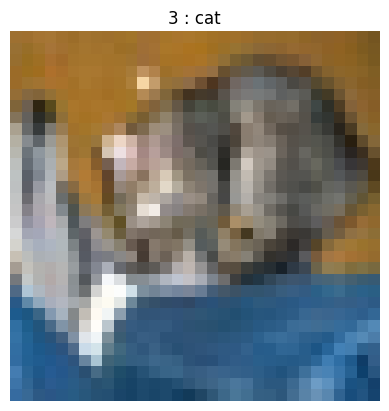

In [10]:
# Plot the image
plt.title(label=f'{target_label} : {cifar10_labels[target_label]}')
plt.imshow(target_img.permute(1,2,0).detach().cpu())
plt.axis('off')
plt.show()

With the data and labels sorted out, let us get the model. We will use the ResNet18 model via transfer learning to help us with this attack. 

### Step 4:

In [11]:
# Set the manual seed
torch.manual_seed(10)

# Get the model
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [12]:
# Look at the model from a different perspective
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

If we look at the last layer **fc**, we see it has **out_features=1000**. This model is currently designed to predict on 1 out of 1000 classes. However, we are using CIFAR10, which has 10 classes. We need to replace this last layer with **out_features=19**.  Let us get to that.  

In [13]:
# Set the random number generator
torch.manual_seed(10)

# Replace the final layer with 10 neurons rather than 1000
model.fc = nn.Linear(in_features=512, out_features=len(cifar10_labels))
model.fc

Linear(in_features=512, out_features=10, bias=True)

We need to extract all the layers except the last. The result from the **adaptiveAvgPool2d** will be used as our features. Setup the feature extractor 

### Step 5:

In [14]:
# Get the target feature information
feature_extractor = nn.Sequential(*list(model.children())[:-1]).eval()

# Extract the features for the samples in the test size 
feature_extractor(test_X.to(device)).size()

torch.Size([1000, 512, 1, 1])

We are on our way. Let us setup the **target_feature**. This is what we would like to model to learn. This target_img if you remember from above, is the cat image that we extracted. We wish to take a sample that has a different label and ensure it is changed to a cat in the targeted case or anything else in the untargeted case.  

### Step 5:

In [15]:
# Use the feature extractor to get the 
with torch.no_grad():
   target_feature =  feature_extractor(target_img.unsqueeze(0))

target_feature.shape

torch.Size([1, 512, 1, 1])

In [16]:
# Setup a function to craft the poison sample
def craft_poison(x, epochs=10):
    # Copy the input
    x = x.clone().requires_grad_(True).to(device)

    # Setup the optimizer
    optimizer = torch.optim.Adam(params=[x], lr=0.01)
    for _ in range(epochs):
        # Extract the features
        feat = feature_extractor(x)

        # Calculate the loss
        loss = nn.MSELoss(reduction='mean')(feat, target_feature)

        # Zero out the gradients
        optimizer.zero_grad(set_to_none=True)

        # Perform backpropagation
        loss.backward()

        # Upgrade the parameters
        optimizer.step()

    return x.detach()

In [17]:
# Test the function
craft_poison(target_img.unsqueeze(0)).shape

torch.Size([1, 3, 32, 32])

In [18]:
# Let us now generate the poison samples
num_poison = 10

# Create a list to store the poison samples and the labels
poisons, labels = [], []

# Loop through the dataset
for img, lbl in trainset:
    img = img.to(device)

    # Check to see if the target label equals the current label
    if lbl != target_label:
        poisons.append(craft_poison(img.unsqueeze(0)))
        labels.append(lbl)

        # Stop once we have 10 samples
        if len(poisons) >= num_poison:
            break
 


With the poison samples generated, we can now add these to the real dataset. The combined set is what we ultimately needs to be retrained. 

### Step 6:

In [19]:
print(f'Poisons are on device: {poisons[0][0].device}')

Poisons are on device: cuda:0


In [20]:
# Need to move to CPU
poisons = [ p.detach().cpu() for p in poisons ]
print(f'Poisons are on device: {poisons[0][0].device}')

Poisons are on device: cpu


In [21]:
# Create a new dataset consisting of the poisoned samples and the labels
poisoned_set = torch.utils.data.TensorDataset(torch.stack(poisons).view(-1, 3, 32, 32), torch.as_tensor(data=labels, dtype=torch.long))


In [22]:
# Combine the poisoned and clean test sets
combined_dataset = torch.utils.data.ConcatDataset(datasets=[trainset, poisoned_set])
combined_dataset


In [23]:
# Create a combined dataloader
combined_loader = DataLoader(dataset=combined_dataset, batch_size=128, shuffle=True)
combined_loader

Train the model with the poisoned samples   

### Step 7:  

In [24]:
# Setup the optimizer
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
model = model.to(device)

# We will keep this simple and go for 5 epochs
epochs = 5

for epoch in range(epochs):
    model.train()
    total, correct = 0, 0 

    # Lop through the combined dataset
    for X, y in combined_loader:
        X, y = X.to(device), y.to(device)

        # Make the forward pass
        preds = model(X)

        # Compute the loss
        loss = nn.CrossEntropyLoss()(preds, y)

        # Clear out any existing gradients
        optimizer.zero_grad()

        # Perform backpropagation 
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Calculate the accuracy
        total += y.size(0)
        correct += preds.argmax(1).eq(y).sum().item()

    print(f'Epoch: {epoch+1}/{epochs} \t loss: {loss} accuracy: {correct/total}')

Epoch: 1/5 	 loss: 0.43311601877212524 accuracy: 0.692001599680064
Epoch: 2/5 	 loss: 0.5319746732711792 accuracy: 0.8155168966206758
Epoch: 3/5 	 loss: 0.40483447909355164 accuracy: 0.861867626474705
Epoch: 4/5 	 loss: 0.3597482442855835 accuracy: 0.8919416116776645
Epoch: 5/5 	 loss: 0.31106406450271606 accuracy: 0.9148970205958808


How does the model perform on the clean test set. To answer that question, let us get the accuracy on the clean test_X   

### Step 8: 

In [25]:
# Get the clean model accuracy on the test set
model.eval()
f'Clean accuracy: {sum(model(test_X.to(device)).detach().cpu().argmax(-1) == test_y)/test_y.shape[0]:.4f}'

'Clean accuracy: 0.8200'

In [26]:
# Get one sample 
X, y = test_X[1].unsqueeze(0), test_y[1]

X.shape, y

(torch.Size([1, 3, 32, 32]), tensor(8))

In [27]:
# Put the model in eval mode
model.eval()

# add a minimal trigger of 1 to the target_img
minimal_trigger = 1.

# You can play around with 1. to other values to see the effect
patch = (target_img * minimal_trigger) 

# Create the adversarial sample
# Clip the values between 0 and 1
adv_sample = torch.clamp(X + patch.detach().cpu(), min=0, max=1).to(device)

# Pass the adversarial samples through the model
adv_out = model(adv_sample).detach().argmax(-1).item()

print(f'Original value is: **{y}** -> Predicted label is: **{adv_out}**')

Original value is: **8** -> Predicted label is: **8**


In this multiclass case, we did not get to change the label to our target 3. However, I am sure playing around with the hyperparameters would get us there. If this was a binary classification problem, I am sure this would be a success.

In [28]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


Visualizing the result   

### Step 9:  

<Figure size 1500x500 with 0 Axes>

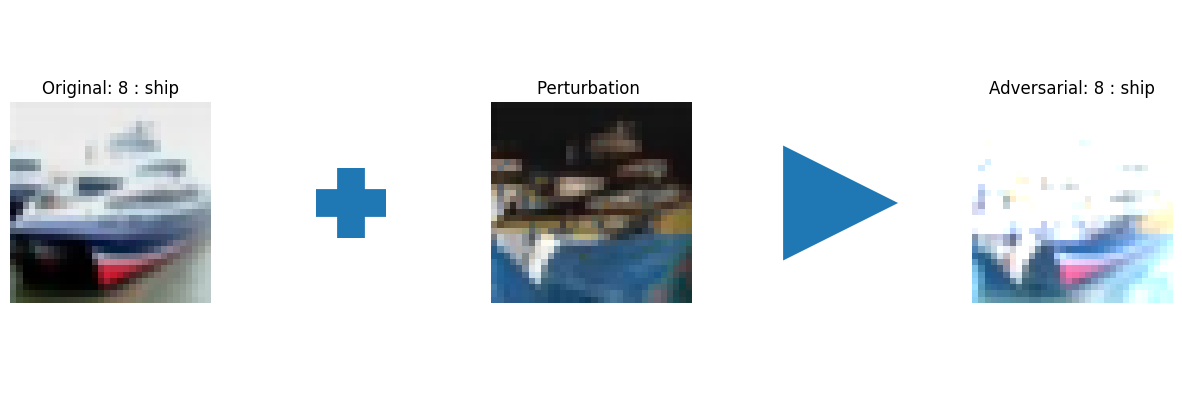

In [29]:
# Visualize, Visualize, Visualize
plt.figure(figsize=(15, 5))

# With everything in place, let's visualize 
plt.figure(figsize=(15, 5))
plt.subplot(1,5,1)
plt.title(label=f'Original: {y} : {cifar10_labels[y]}')
plt.imshow(X=X.detach().cpu().squeeze(0).permute(1,2,0))
plt.axis('off')

plt.subplot(1, 5, 2)
plt.plot([5], marker='+', markersize=50, mew=20)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title(label=f'Perturbation ')
plt.imshow(X=(adv_sample.detach().cpu() - X).squeeze(0).permute(1,2,0)  )
plt.axis('off')

plt.subplot(1, 5, 4)
plt.plot([5], marker='>', markersize=50, mew=20)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title(label=f'Adversarial: {adv_out} : {cifar10_labels[adv_out]}')
plt.imshow(X=adv_sample.detach().cpu().squeeze(0).permute(1,2,0))
plt.axis('off')

plt.show()

### Lab Takeaways:  
- We got a solid understanding of the clean label attack  
- We built a simplified version of the clean label attack  
- We leveraged transfer learning to build our model rather than starting from scratch
- This concept of transfer learning will be used again, when building our malware detection tool